### TODO

- Find the right way to turn the solution into integers

In [52]:
from random import randint
import sys

import numpy as np
import scipy.optimize as optimize
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%xmode plain

def init_simulation(num_nodes, 
                    num_days, 
                    icu_capacities = None, 
                    transport_capacities = None, 
                    ini_path = None, 
                    demand_min = 80, 
                    demand_max = 90,
                    icu_min = 10,
                    icu_max = 300,
                    transport_min = 20,
                    transport_max = 30):
    if ini_path:
        print("you can also upload an .ini file")
        raise NotImplemented
    else:
        demand = []
        for node in range(num_nodes):
            demand.append(list(np.random.randint(demand_min, demand_max, size = num_days)))
        
        icu_capacities = icu_capacities if icu_capacities else list(np.random.randint(icu_min, 
                                                                                      icu_max, 
                                                                                      size = num_nodes))
        transport_capacities = transport_capacities if transport_capacities else list(np.random.randint(transport_min, 
                                                                                                        transport_max, 
                                                                                                        size = num_nodes)) 
    return icu_capacities, transport_capacities, demand


def calculate_outgoing(array,day,node):
    return sum(array[day][node])


def calculate_incoming(array,day,node):
    total_outgoing = 0
    for n in range(num_nodes):
        total_outgoing = total_outgoing + array[day][n][node]
    return total_outgoing


def demand_day_node_raw(node_capacity, demand_day, left_day, received_day, demand_previous_days, left_previous_days, received_previous_days):
    return demand_day - left_day + received_day+ min(demand_previous_days-left_previous_days+received_previous_days, node_capacity)


def demand_day_node(movements,day,node):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    total_received_patients = 0
    total_outbound_patients = 0
    accumulated_demand = 0
    for d in range(day):
        total_received_patients = total_received_patients + calculate_incoming(movements_res,d,node)
        total_outbound_patients = total_outbound_patients + calculate_outgoing(movements_res,d,node)
    accumulated_demand = sum(demands[node][:day])
    
    demand = max(0, demand_day_node_raw(node_capacities[node],demands[node][day], 
                                        calculate_outgoing(movements_res,day,node), calculate_incoming(movements_res,day,node),
                                        accumulated_demand, total_outbound_patients, total_received_patients                
                ))
    return demand


def calc_total_deaths(movements):
    total = 0
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    for node in range(num_nodes):
        for day in range(num_days):
            deaths_not_attended = max(0, demand_day_node(movements,day,node) - node_capacities[node])
            deaths_transport = prob_death_transport*movements_res[day].sum()
            total = total + deaths_not_attended + deaths_transport
    return total


def outgoing_list(movements):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    outgoing_list = list()
    for day in range(num_days):
        for node in range(num_nodes):
            outgoing_list.append(calculate_outgoing(movements_res,day,node))
    return outgoing_list

def generate_bounds():
    outgoing_list = list()
    for day in range(num_days):
        for outgoing_node in range(num_nodes):
            for incoming_node in range(num_nodes):
                outgoing_list.append((0,transport_capacities[outgoing_node]))
    return outgoing_list

def f_cons(node_id, day):
    return lambda x: transport_capacities[node_id] - calculate_outgoing(np.reshape(x,(num_days,num_nodes,num_nodes)),day ,node_id)


def split_n(num, num_nodes):
    #TODO this function is not truly random
    pieces = []
    for idx in range(num_nodes-1):
        pieces.append(randint(1,num-sum(pieces)-num_nodes+idx))

    pieces.append(num-sum(pieces))
    return pieces

Exception reporting mode: Plain


In [16]:
prob_death_transport = 0
num_days = 5
num_nodes = 4
node_capacities, transport_capacities, demands = init_simulation(num_nodes, 
                                                                 num_days, 
                                                                 icu_capacities=[30000, 20, 80, 1000],
                                                                 transport_capacities=[50, 60, 70, 80], 
                                                                 demand_min = 60, demand_max=100)
print(f"""Randomly generated
{num_days} days, {num_nodes} hospitals
ICU capacities of hospitals: {node_capacities}
Daily transport capacities: {transport_capacities}, 
Daily simulated demand (from uniform distrution): 
{demands}""")

Randomly generated
5 days, 4 hospitals
ICU capacities of hospitals: [30000, 20, 80, 1000]
Daily transport capacities: [50, 60, 70, 80], 
Daily simulated demand (from uniform distrution): 
[[89, 68, 65, 74, 64], [98, 82, 60, 80, 76], [77, 70, 75, 72, 69], [85, 62, 79, 70, 74]]


In [17]:
#define constraints
cons = []
for node in range(num_nodes):
    for day in range(num_days):
        cons.append({'type': 'ineq', 'fun': f_cons(node,day)})

        
#no movement matrix, the base for generating random ones and one of the ones to test as init matrix 
no_movement = np.array([[[0]*num_nodes]*num_nodes]*num_days)

In [33]:
bool(np.array([1]).any())

True

In [42]:
def random_init(knockdown_days = False, movement_intensity = 1, random_intensity = False, prior_matrix = np.array([])): 
    random_movement = prior_matrix.copy() if prior_matrix.any() else no_movement.copy()
    #if knockdown days is active, behave like a dropdown NN layer and drop half of the days movements
    active_days = np.random.choice([1,0], size=num_days) if knockdown_days else [1]*num_days
    for day in range(num_days):
        if active_days[day]:
            for node_x in range(num_nodes):
                movement_intensity = np.random.uniform() if random_intensity else movement_intensity
                #splits a number in a list of numbers pseudo randomly
                split_nodes = split_n(max(num_nodes+1, 
                                          np.ceil(transport_capacities[node_x]*movement_intensity)), 
                                      num_nodes)
                for node_y in range(num_nodes):
                    if node_x != node_y: #the ones that move to "self" are actually staying
                        random_movement[day, node_x, node_y] += split_nodes[node_y]
                    
    return random_movement

### The main loop that generates random init matrices

In [63]:
%%time

#parameters to minimize
min_deaths = sys.maxsize
best_result = None
result_matrix = None
#iterate through low to high intensity movement simulation
steps = []
knockdown = True
random_intensity = False
win_init_matrix = no_movement.copy()
iterations = 1000
movement_intensity = 0.1
for i in range(iterations):
    print(f"i:{i} ", end="")
    movement = random_init(knockdown, movement_intensity=movement_intensity, prior_matrix=win_init_matrix)
    bounds_movement = generate_bounds()
    result = optimize.minimize(calc_total_deaths, 
                               movement, 
                               method='SLSQP', 
                               constraints=cons, 
                               bounds=bounds_movement)

    current_deaths = calc_total_deaths(np.rint(result.x))
    print(f"Result:{current_deaths:.0f}", end="")
    steps.append([movement_intensity, knockdown, current_deaths])
    if min_deaths >= current_deaths: 
        print(" <--best!", end="")
        min_deaths = int(current_deaths)
        best_result = result
        result_matrix = np.reshape(np.rint(result.x),(num_days,num_nodes,num_nodes))
        win_init_matrix = movement

    print("")
        
print("\nDone")

i:0 Result:76 <--best!
i:1 Result:77
i:2 Result:77
i:3 Result:79
i:4 Result:78
i:5 Result:74 <--best!
i:6 Result:79
i:7 Result:76
i:8 Result:79
i:9 Result:73 <--best!
i:10 Result:75
i:11 Result:79
i:12 Result:78
i:13 Result:75
i:14 Result:75
i:15 Result:76
i:16 Result:78
i:17 Result:76
i:18 Result:76
i:19 Result:75
i:20 Result:79
i:21 Result:80
i:22 Result:79
i:23 Result:76
i:24 Result:75
i:25 Result:77
i:26 Result:76
i:27 Result:74
i:28 Result:76
i:29 Result:79
i:30 Result:73 <--best!
i:31 Result:78
i:32 Result:78
i:33 Result:77
i:34 Result:75
i:35 Result:78
i:36 Result:75
i:37 Result:79
i:38 Result:77
i:39 Result:78
i:40 Result:76
i:41 Result:78
i:42 Result:77
i:43 Result:78
i:44 Result:74
i:45 Result:80
i:46 Result:80
i:47 Result:77
i:48 Result:79
i:49 Result:77
i:50 Result:78
i:51 Result:77
i:52 Result:75
i:53 Result:75
i:54 Result:73 <--best!
i:55 Result:77
i:56 Result:75
i:57 Result:80
i:58 Result:77
i:59 Result:78
i:60 Result:76
i:61 Result:78
i:62 Result:77
i:63 Result:75
i:64 

i:504 Result:81
i:505 Result:72 <--best!
i:506 Result:77
i:507 Result:76
i:508 Result:73
i:509 Result:77
i:510 Result:76
i:511 Result:78
i:512 Result:78
i:513 Result:78
i:514 Result:76
i:515 Result:78
i:516 Result:75
i:517 Result:75
i:518 Result:78
i:519 Result:76
i:520 Result:78
i:521 Result:78
i:522 Result:79
i:523 Result:78
i:524 Result:80
i:525 Result:74
i:526 Result:76
i:527 Result:79
i:528 Result:79
i:529 Result:79
i:530 Result:78
i:531 Result:78
i:532 Result:78
i:533 Result:74
i:534 Result:74
i:535 Result:79
i:536 Result:75
i:537 Result:74
i:538 Result:77
i:539 Result:77
i:540 Result:78
i:541 Result:76
i:542 Result:72 <--best!
i:543 Result:74
i:544 Result:77
i:545 Result:80
i:546 Result:75
i:547 Result:80
i:548 Result:75
i:549 Result:74
i:550 Result:78
i:551 Result:78
i:552 Result:79
i:553 Result:79
i:554 Result:77
i:555 Result:75
i:556 Result:75
i:557 Result:76
i:558 Result:72 <--best!
i:559 Result:75
i:560 Result:77
i:561 Result:75
i:562 Result:74
i:563 Result:73
i:564 Result:

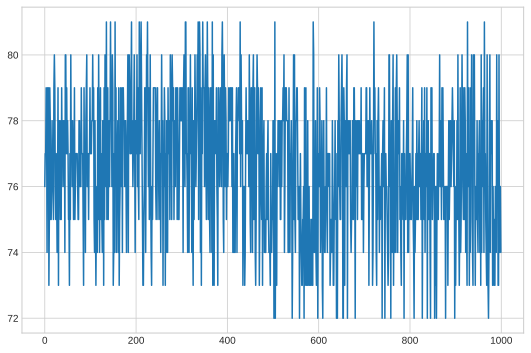

In [65]:
df = pd.DataFrame(steps)
df.columns = ["movement_intensity", "knockdown", "result"]
df.result.plot(figsize=(9, 6));

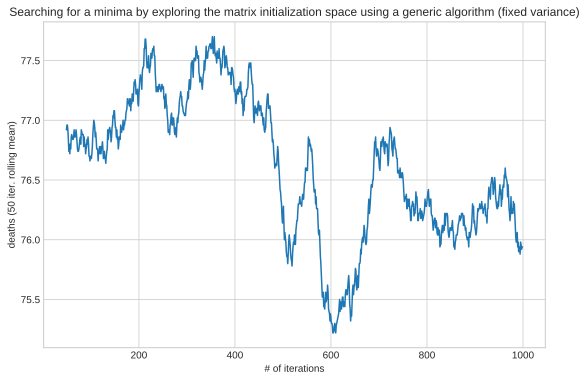

In [79]:
df.result.rolling(50).mean().plot(figsize=(9, 6), title="Searching for a minima by exploring the matrix initialization space using a generic algorithm (fixed variance)")
plt.xlabel("# of iterations")
plt.ylabel("deaths (50 iter. rolling mean)");

In [284]:
df.groupby("knockdown").agg([np.mean, np.median, np.std])["result"]

,mean,median,std
knockdown,,,
False,188.926829,188.0,2.961336
True,188.414634,188.0,2.559059


### These are the deaths that we get with inaction

In [264]:
calc_total_deaths(no_movement)

1457

### This is the best result found

In [265]:
min_deaths

183

### This the movement matrix

In [266]:
result_matrix

array([[[ 0.,  0.,  0.,  0.],
        [39.,  0.,  2., 20.],
        [45.,  0.,  0., 25.],
        [19.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [39.,  0.,  2., 20.],
        [45.,  0.,  0., 25.],
        [19.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [39.,  0.,  2., 20.],
        [45.,  0.,  0., 25.],
        [19.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [38.,  0.,  2., 19.],
        [43.,  0.,  0., 25.],
        [28.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [39.,  0.,  2., 20.],
        [45.,  0.,  0., 25.],
        [19.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [39.,  0.,  2., 20.],
        [45.,  0.,  0., 25.],
        [19.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  2.],
        [41.,  0.,  0., 19.],
        [46.,  0.,  0., 24.],
        [25.,  0.,  2.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [41.,  0.,  1., 19.],
        [42.,  0.,  0., 24.],
        [23.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., 

In [267]:
for node in range(num_nodes):
    for day in range(num_days):
        print(f'Node: {node}, Day: {day}, Demand: {demand_day_node(np.rint(result.x),day,node)}')

Node: 0, Day: 0, Demand: 196.0
Node: 0, Day: 1, Demand: 373.0
Node: 0, Day: 2, Demand: 612.0
Node: 0, Day: 3, Demand: 855.0
Node: 0, Day: 4, Demand: 1107.0
Node: 0, Day: 5, Demand: 1304.0
Node: 0, Day: 6, Demand: 1547.0
Node: 0, Day: 7, Demand: 1676.0
Node: 0, Day: 8, Demand: 1855.0
Node: 0, Day: 9, Demand: 2014.0
Node: 1, Day: 0, Demand: 40.0
Node: 1, Day: 1, Demand: 53.0
Node: 1, Day: 2, Demand: 45.0
Node: 1, Day: 3, Demand: 37.0
Node: 1, Day: 4, Demand: 46.0
Node: 1, Day: 5, Demand: 32.0
Node: 1, Day: 6, Demand: 42.0
Node: 1, Day: 7, Demand: 25.0
Node: 1, Day: 8, Demand: 29.0
Node: 1, Day: 9, Demand: 36.0
Node: 2, Day: 0, Demand: 0
Node: 2, Day: 1, Demand: 6.0
Node: 2, Day: 2, Demand: 0
Node: 2, Day: 3, Demand: 20.0
Node: 2, Day: 4, Demand: 33.0
Node: 2, Day: 5, Demand: 45.0
Node: 2, Day: 6, Demand: 38.0
Node: 2, Day: 7, Demand: 57.0
Node: 2, Day: 8, Demand: 62.0
Node: 2, Day: 9, Demand: 73.0
Node: 3, Day: 0, Demand: 73.0
Node: 3, Day: 1, Demand: 174.0
Node: 3, Day: 2, Demand: 215.0